# Search Forecasting

> A Robust Statistical Approach

In [ ]:
#| hide
import warnings

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
#| eval: false
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from typing import Callable, Tuple, Protocol
from abc import ABC, abstractmethod

from pymc_marketing.mmm.transformers import batched_convolution
import pymc_marketing as pm_mrk
from pymc_marketing.prior import handle_dims
import pymc as pm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from tueplots import bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes


import pytensor.tensor as pt
import dowhy

from search_forecast.utils.data_gen import generate_data_search_data
from search_forecast.wrapper.pymc_wrapper import (
    Prior, HSGP, HSGPPeriodic,
    YearlyFourier, Data, WeeklyFourier
)
from search_forecast.utils.data_gen import (
    hill
)

In [ ]:
#| hide
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})

plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
plt.rcParams.update(
    **{'figure.figsize': (8,4.5),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.05,
 'font.size': 16,
 'axes.labelsize': 12,
 'legend.fontsize': 8,
 'xtick.labelsize': 8,
 'ytick.labelsize': 8,
 'axes.titlesize': 12})

In [ ]:
#| hide
causal_graph = """digraph {
geo -> search_volume;
time -> search_volume;
time -> budget;
time -> observed_clicks;
geo -> budget;
budget -> impressions;
search_volume -> impressions;
impressions -> observed_clicks;
}"""

In [ ]:
#| hide
data = generate_data_search_data()

This document presents a formal analysis of our probabilistic search advertising model, demonstrating how it effectively captures the relationship between marketing expenditure and business outcomes. Using synthetic data that mirrors real-world advertising patterns, we illustrate the model's structure, statistical properties, and practical applications for optimizing advertising investments.

## Introduction: The Search Advertising Journey

Search advertising represents a complex ecosystem where multiple factors interact to determine your business outcomes. At its core, the process follows this path:

1. **Users search** for terms related to your products or services
2. **Your budget** competes for visibility among these searches
3. **Impressions** are generated when your ads appear in search results
4. **Users click** on a portion of these impressions, driving traffic to your site

While this flow seems straightforward, accurately modeling and predicting these relationships is challenging. Traditional approaches often make simplistic assumptions that don't capture real-world complexities:

- **Linear models** incorrectly assume doubling your budget doubles your results
- **Single-factor models** miss the interplay between seasonality, geography, and competition
- **Deterministic approaches** fail to account for inherent uncertainty in user behavior

Our Bayesian hierarchical model overcomes these limitations by respecting the true causal structure of search advertising and quantifying uncertainty at each step.

## The Causal Structure: Understanding What Drives What

The foundation of our model is a causal graph that represents how different variables influence each other:

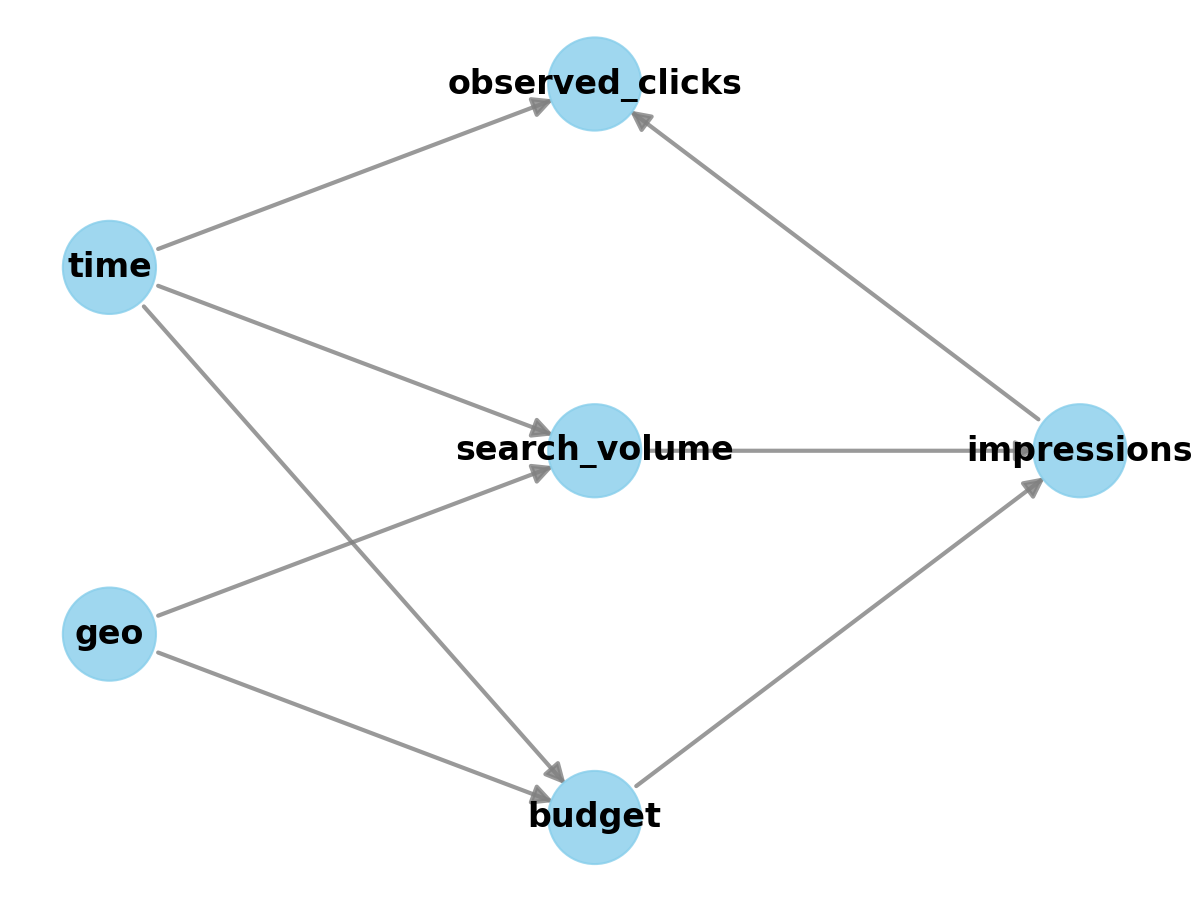

In [ ]:
#| echo: False
#| label: fig-causal-graph
#| fig-cap: Causal graph for the search volume model.
model = dowhy.CausalModel(
    data=data.to_dataframe(),
    graph=causal_graph.replace("\n", " "),
    treatment="budget",
    outcome="observed_clicks",
)
model.view_model()

This causal structure encodes several key insights:

- **Search volume** is determined by time (seasonality) and geographic factors, **not** by your budget
- **Budget** directly influences impressions but has no direct effect on search volume
- **Impressions** are constrained by both budget and available search volume
- **Clicks** come only from impressions, with rates influenced by time and geography

This separation of factors you control (budget) from those you don't (market demand) provides clarity about what marketing levers you can pull and their expected effects.

## The Data: What We're Modeling

To demonstrate the model, let's examine some synthetic data that captures typical patterns in search advertising:

::: {.panel-tabset}

## Search Volume

**The Market Opportunity**

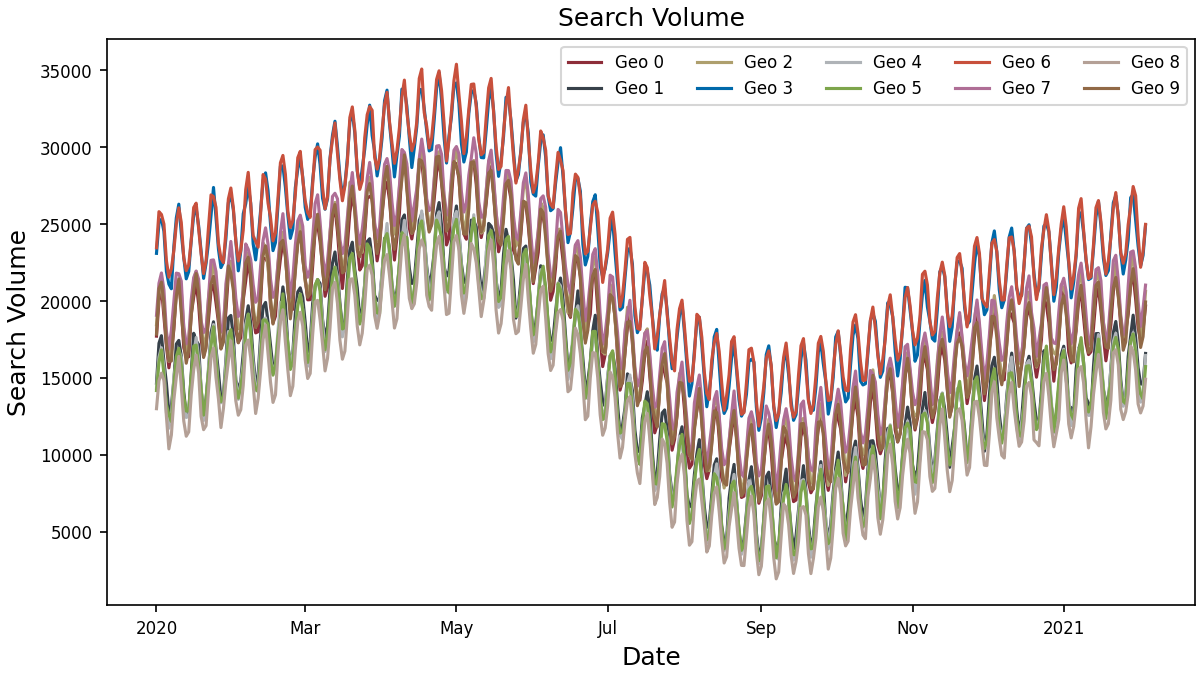

In [ ]:
#| echo: False
#| label: fig-avg-search-volume
#| fig-cap: Search Volume across geographies, showing a strong seasonal patterns at both the weekly and yearly level.
fig, ax = plt.subplots()
ax = data.search_volume.plot.line(x="date", hue="geo", ax=ax);
plt.legend(handles=ax, labels=[f"Geo {i}" for i in range(len(ax))], ncols=5);
plt.title("Search Volume");
plt.ylabel("Search Volume");
plt.xlabel("Date");

Search volume represents the total market opportunity—how many people are searching for relevant terms. Notice in @fig-avg-search-volume:

- **Annual seasonality**: In this example, peak volume occurs around April-May with lowest volume in September
- **Weekly cycles**: Regular oscillations show higher weekday searches and weekend drops
- These patterns exist **regardless of your advertising budget**

## Budget Allocation

**Your Strategic Decisions**

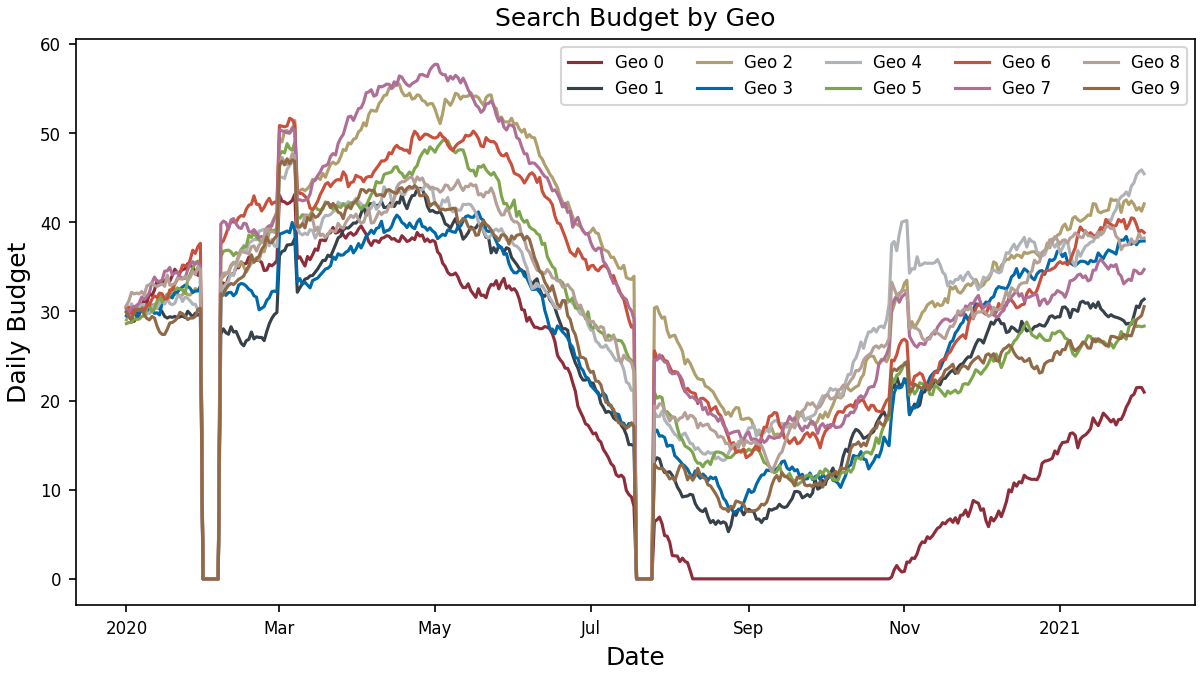

In [ ]:
#| echo: False
#| fig-cap: Budget allocation across geographies over time, showing a strong seasonal pattern and geos with little to no budget.
#| label: fig-budget-allocation


fig, ax = plt.subplots()
ax = data.budget.plot.line(x="date", hue="geo", ax=ax);
plt.legend(handles=ax, labels=[f"Geo {i}" for i in range(len(ax))], ncols=5);
plt.ylabel("Daily Budget")
plt.title("Search Budget by Geo");
plt.xlabel("Date");

Budget allocation shows how you're distributing your advertising spend:

- **Varying levels** across different geographic regions
- **Seasonal adjustments** that often (but not always) mirror search volume patterns
- **Strategic pauses** where budget drops to zero in specific regions


## Impressions

**Your Market Visibility**

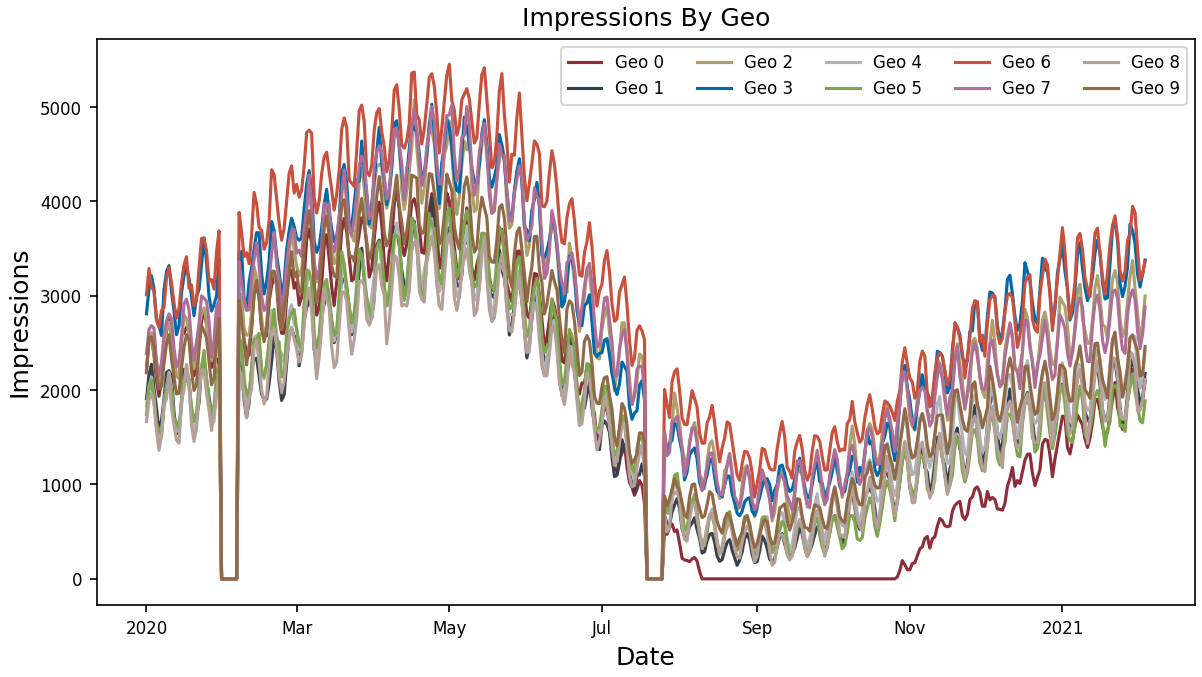

In [ ]:
#| echo: false
#| label: fig-imp-data
#| fig-cap: Impressions show a strong seasonal pattern and geos with little to no impressions.
fig, ax = plt.subplots()
ax = data.impressions.plot.line(x="date", hue="geo", ax=ax);
plt.legend(handles=ax, labels=[f"Geo {i}" for i in range(len(ax))], ncols=5);
plt.title("Impressions By Geo");
plt.ylabel("Impressions");
plt.xlabel("Date");

Impressions represent how many times your ads appear in search results:

- **Seasonal patterns** similar to search volume
- **Sharp drops to zero** when budget is paused
- **Immediate recovery** when budget resumes

## Clicks

**Your success rate**

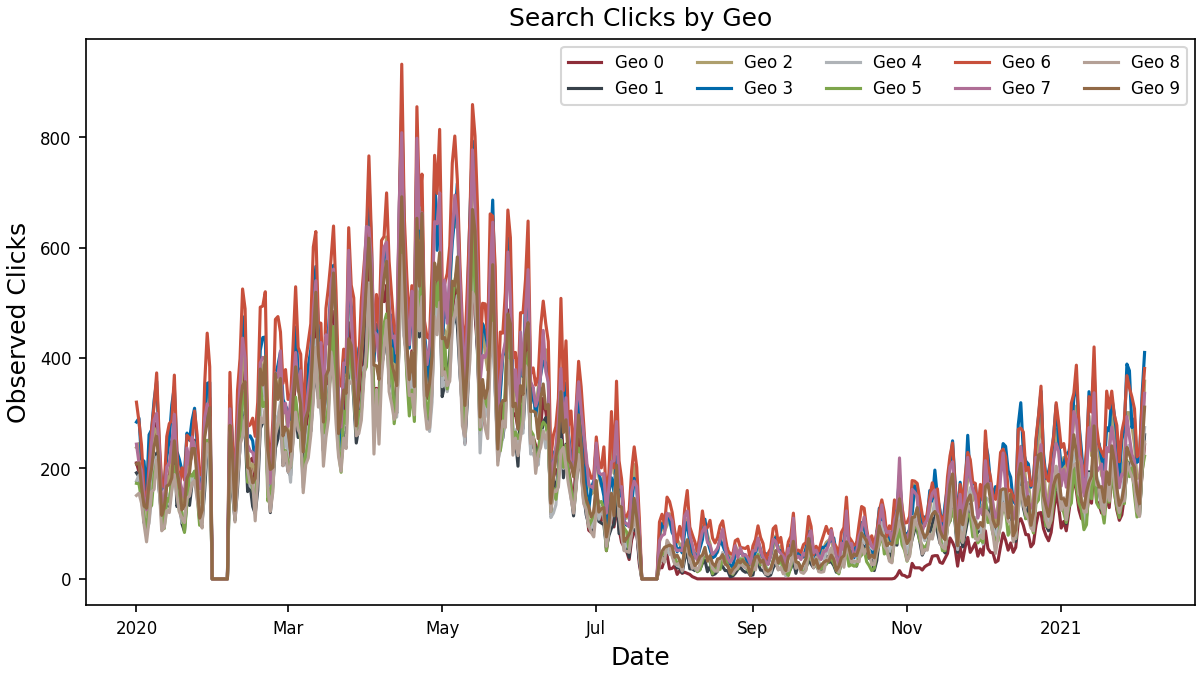

In [ ]:
#| echo: False
#| fig-cap: Synthetic click data.
#| label: fig-click-data


fig, ax = plt.subplots()
ax = data.observed_clicks.plot.line(x="date", hue="geo", ax=ax);
plt.legend(handles=ax, labels=[f"Geo {i}" for i in range(len(ax))], ncols=5);
plt.ylabel("Observed Clicks")
plt.xlabel("Date")
plt.title("Search Clicks by Geo");

Observed clicks tend to have a seasonal and yearly patternd driven by the effects of search volume, search impressions and consumer behaviors. Notice:

- Clicks drop to zero when impressions drop to zero
- Strong seasonal patterns are present at both weekly and yearly levels

:::

### The Budget-Results Relationship: Diminishing Returns

The relationship between budget and results (clicks/impressions) is clearly non-linear:

- **Initial slow growth**: At low budget levels (100-200), each additional dollar yields modest increases
- **Acceleration phase**: At middle budget ranges (200-300), returns improve
- **Diminishing returns**: At higher levels (400+), additional spending faces decreasing efficiency
- **Variability**: Even at the same budget level, results vary due to seasonal factors

This non-linear pattern reflects real-world marketplace dynamics, where competition and saturation limit the effectiveness of additional spending.

::: {.panel-tabset}

## Budget-Impressions

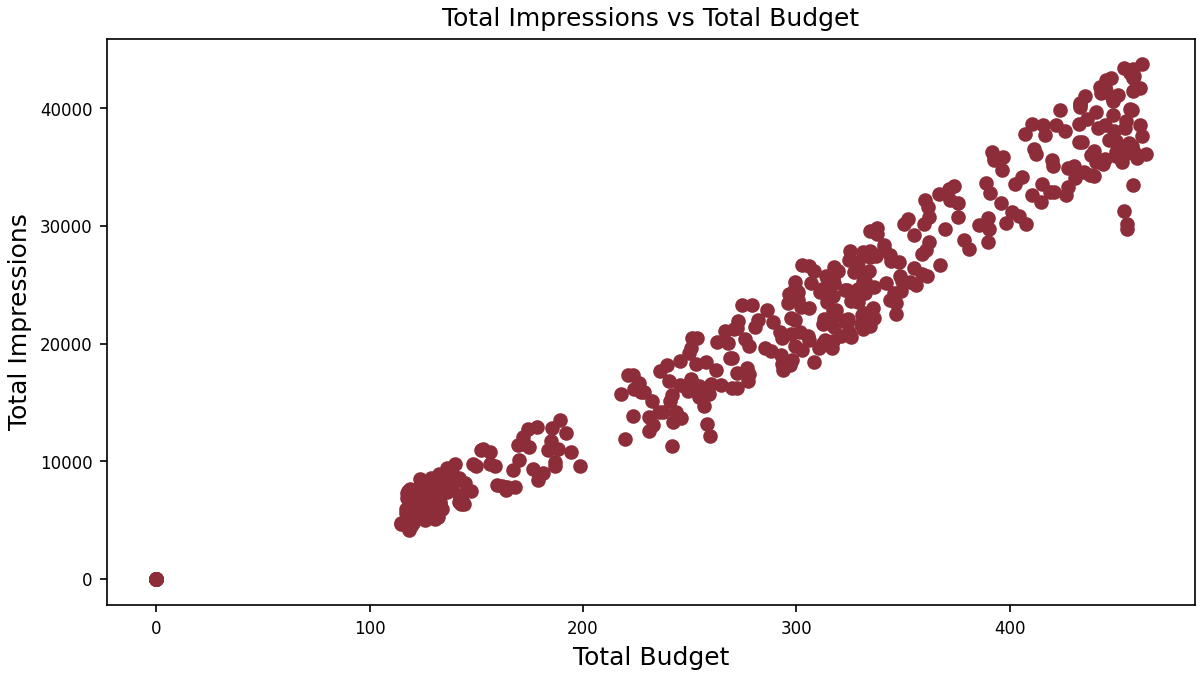

In [ ]:
#| echo: False
#| label: fig-imp-response
#| fig-cap: Observed relationship between budget and impressions.

plt.scatter(data.budget.sum("geo").values, (data.impressions.sum("geo")).values)
plt.xlabel("Total Budget")
plt.ylabel("Total Impressions")
plt.title("Total Impressions vs Total Budget");

## Click Response to Budget

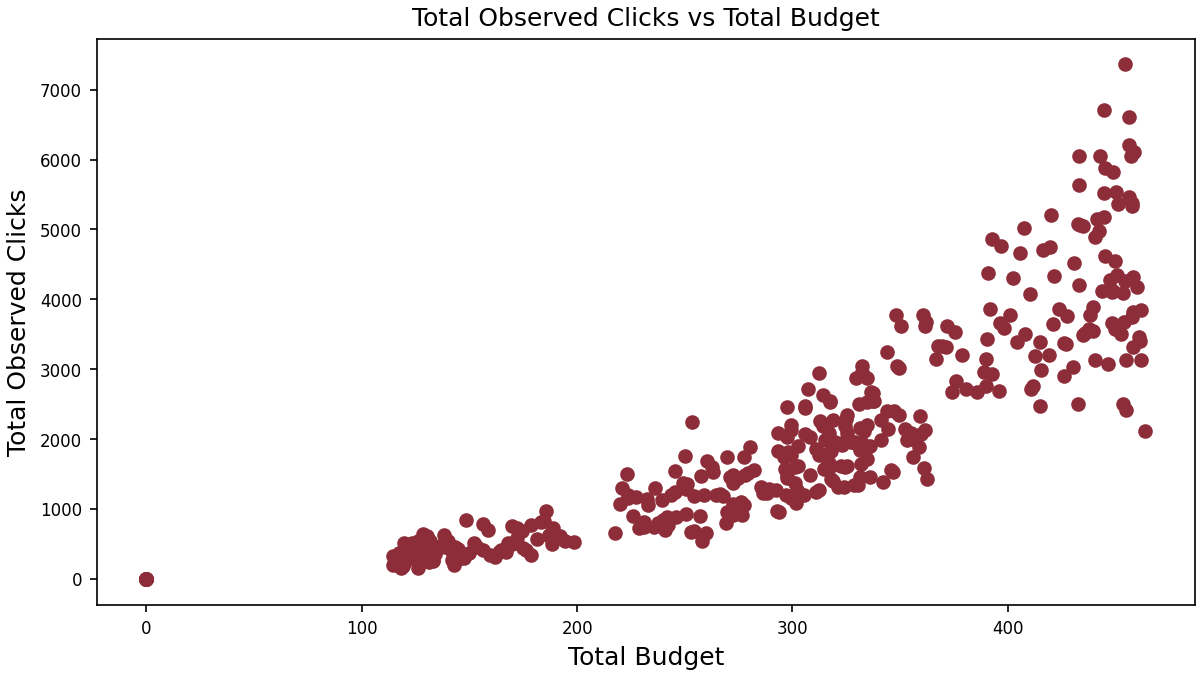

In [ ]:
#| echo: False
#| label: fig-click-response
#| fig-cap: Observed relationship between budget and observed clicks.

plt.scatter(data.budget.sum("geo").values, (data.observed_clicks.sum("geo")).values)
plt.xlabel("Total Budget")
plt.ylabel("Total Observed Clicks")
plt.title("Total Observed Clicks vs Total Budget");

:::

## The Model Structure: Three Interconnected Components

Our forecasting system models this process through 4 interconnected components, each with its own statistical approach:

1. **Defining Inputs and Statistical Controls**
   - Build components for **seasonality** and **trends**
   - Account for different base levels for different **geographies**
   - Add noise to account for shocks

2. **Search Volume Forecasting**
   - Projects underlying market demand independent of your advertising
   - Accounts for both weekly cycles and yearly seasonality
   - Adjusts for geographic differences in search behavior

3. **Impression Generation**
   - Models how your budget converts search volume into impressions
   - Captures the "hill function" effect where budget increases face diminishing returns
   - Identifies periods of zero impressions when budget is paused

4. **Click-Through Prediction**
   - Estimates conversion from impressions to valuable clicks
   - Accounts for seasonal variations in consumer engagement
   - Reflects geographic differences in click behavior

### 1. Defining Inputs and Statistical Controls

Looking at the causal graph (@fig-causal-graph), we can see how information flows through the model:

1. **External Factors First**: Time and geography are the foundation variables that influence everything else
2. **Search Volume Generation**: These external factors determine how many people search for relevant terms
3. **Budget Allocation**: Your marketing spend determines what portion of searches become impressions
4. **Conversion Process**: Impressions then convert to clicks based on various factors

This structure accurately represents real-world advertising dynamics where you can control your budget but not consumer search behavior.

In [ ]:
#| lst-label: lst-data
#| lst-cap: Define the main inputs to the model for this example only time and budget are used.

# Date to be used as a time index in the model 
time_data = Data('time', dims=('date')) 

# Budget to be used as a covariate in the model
budget_data = Data('budget', dims=('date', 'geo')) 

Statistical controls can be used when data or theory is not available to ascribe cause to any particular variable.
They allow use to seperate noise and things outside our control from the factors we are interested in studying (budget allocation).
If theory suggests other explanatory variables for which data is available that explain the variation in the data they should be used instead.

In [ ]:
#| code-fold: true
#| lst-label: lst-long-term-periodic
#| lst-cap: Define a long-term periodicity prior for the model.

# Length scale prior for the long-term periodicity
# The length scale defines the smoothness of the periodic function
# A small length scale means that the function will vary quickly, 
# while a large length scale means that the function will vary slowly
# The length scale is a hyperparameter that can be learned from the data
# Because the length scale is positive, we use a gamma prior
ls_long_periodic = Prior(
    'ls_lp', 
    prior_name="Gamma", 
    alpha=1, 
    beta=1/5
)

# Scale prior for the long-term periodicity
# The scale defines the amplitude of the periodic function
# A small scale means that the function will be small,
# while a large scale means that the function will be large
# The scale is a hyperparameter that can be learned from the data
# Because the scale is positive and it may be large, we use an exponential prior
scale_long_periodic = Prior(
    'scale_lp',
    prior_name="Exponential",
    lam=1/100.0)

# A Gaussian process prior for the long-term periodicity
# This prior is used to model time-varying effects
# This allows for the model to capture long-term trends in the data
long_periodic = HSGPPeriodic(
    "long_term_periodic",
    m=40, # Rank of the GP approximation
    ls=ls_long_periodic,
    scale=scale_long_periodic,
    dims=('date', 'geo'), # Varies by date and geo
    period=365 # yearly 
)

In [ ]:
#| lst-label: lst-long-term-periodic-ctr
#| lst-cap: Define a long-term periodicity prior for click-through-rate (CTR). This allows for the model to capture long-term trends in the CTR data separately from the impressions data.

# Hyperparameters for the long-term periodicity prior for CTR
ls_long_periodic_ctr = Prior(
    "ls_lp_ctr",
    prior_name="Gamma", 
    alpha=1, 
    beta=1/5
    )
scale_long_periodic_ctr = Prior(
    "scale_lp_ctr", 
    prior_name="Exponential", 
    lam=1
    )

long_periodic_ctr = HSGPPeriodic(
    "long_term_periodic_ctr",
    m=40,
    ls=ls_long_periodic_ctr,
    scale=scale_long_periodic_ctr,
    dims=('date', 'geo'),
    period=365 # yearly
)

In [ ]:
#| lst-label: lst-weekly-periodic
#| lst-cap: Define a weekly periodicity prior for the model. Fourier basis functions are used to model the weekly periodicity.

# Weekly periodic component
weekly_periodic = WeeklyFourier(
    name='weekly_periodic',
    n_order=3, # Number of Fourier basis functions to use
    prefix='weekly_search_volume',
    dims=('date',)
    )

In [ ]:
#| lst-label: lst-short-term-periodic-ctr
#| lst-cap: Define a short-term periodicity prior for CTR. Assumes a weekly periodicity which may be different from the weekly periodicity of the impressions.

ls_short_periodic = Prior("ls_sp", prior_name="Gamma", alpha=1, beta=1/30) # <1>
scale_short_periodic = Prior("scale_sp", prior_name="Exponential", lam=1)

short_periodic_ctr= HSGPPeriodic(
    "short_term_periodic_ctr",
    m=40,
    ls=ls_long_periodic,
    scale=scale_long_periodic,
    dims=('date', 'geo'),
    period=7 # weekly
)


In [ ]:
#| lst-label: lst-geo-effects-volume
#| lst-cap: Define a hierarchical prior for geographic effects for the search volume. This allows for the model to capture geographic effects in the search volume data.

# Average search volume over all geographies
mean_search_volume = Prior(
            "base_volume_mu", 
            prior_name="Normal", 
            mu=22000, 
            sigma=8000
)

# Hyperparameters for the amount of pooling between geographies
amount_of_pooling_volume = Prior(
        "base_volume_sigma", 
        prior_name="HalfNormal", 
        sigma=500
)

# Random effects by geo for the search volume
volume_random_effects = Prior(
        "base_volume_random_effects",
        prior_name="Normal",
        mu=0,
        sigma=amount_of_pooling_volume,
        dims=('geo',)
    )

base_volume = (mean_search_volume + volume_random_effects)

In [ ]:
#| lst-label: lst-volume-shocks
#| lst-cap: Search volume may be affected by shocks. These are small random variations in the search volume data at the day and geo level.

daily_geo_shocks_search_volume = Prior(
        "daily_geo_shocks_search_volume",
        prior_name="Normal", 
        mu=0, 
        sigma=Prior(
            "daily_geo_shocks_search_volume_scale", 
            prior_name="HalfCauchy", 
            beta=1
        ), 
        dims=('date', 'geo')
    )

### 2. Search Volume Component
This predicts the underlying market demand:

- **Base Volume**: A normal distribution representing the average search volume for each geographic region [Code -@lst-geo-effects-volume]
- **Temporal Patterns**: 
  - Weekly seasonal components (captured by Fourier series [Code -@lst-weekly-periodic])
  - Long-term periodic components (captured by Hilbert Space Gaussian Processes [Code -@lst-long-term-periodic])
- **Geographic Variations**: Random effects that account for differences between markets [Code -@lst-geo-effects-volume]
- **Daily Shocks**: Random variations that capture unexpected search behavior fluctuations [Code -@lst-volume-shocks]

The model assumes search volume follows a Poisson distribution, which is ideal for count data and allows for appropriate variance as volume increases. [Code -@lst-search-volume-model-obs]

In [ ]:
#| lst-label: lst-search-volume-model
#| lst-cap: Define the model for the mean search volume. This is a linear model with a long-term periodicity, weekly periodicity, geographic effects and daily shocks.

# The mean search volume must be positive, so we use a softplus transformation 
# an exponential transformation could also be used but then all the priors must be 
# in the log domain
# The softplus transformation is a smooth approximation of the ReLU function
search_volume_lam = ((
    long_periodic 
    + weekly_periodic
    + base_volume
    + daily_geo_shocks_search_volume
    )(time_data)).transform(pt.softplus)


In [ ]:
#| hide
coords = {
    "date": data.date.values[:100],
    "geo": data.geo.values
}
time_index = np.arange(100)

In [ ]:
#| lst-label: lst-search-volume-model-obs
#| lst-cap: Define the model for the observed search volume. This is a Poisson distribution with a mean defined by the search volume model.
with pm.Model(coords=coords) as search_model:
    lam = handle_dims(
        search_volume_lam.apply(time_index), 
        search_volume_lam._dims, 
        ("date", "geo")
    )
    search_volume_obs = pm.Poisson(
        "search_volume_obs",
        mu=lam,
        dims=("date", "geo"),
    )

In [ ]:
#| echo: false
draws = pm.draw(search_volume_obs, 1000, random_seed=42)
draws = xr.DataArray(
    draws,
    dims=("draw", "date", "geo"),
    coords={
        "draw": np.arange(1000),
        "date": data.date.values[:100],
        "geo": data.geo.values
    },
)

::: {.callout-note}
## Key assumptions and justifications:
- **Poisson distribution** for search volume: Appropriate for count data with variance proportional to the mean
- **Gaussian Process priors** for seasonality: Allows flexible modeling of complex patterns without rigid assumptions
- **Hierarchical structure** for geographic effects: Shares information across regions while allowing for differences
- **Additive components**: Each factor (weekly patterns, yearly seasonality, etc.) contributes independently to the overall trend
:::

::: {.panel-tabset}

## Simulated Search Volume

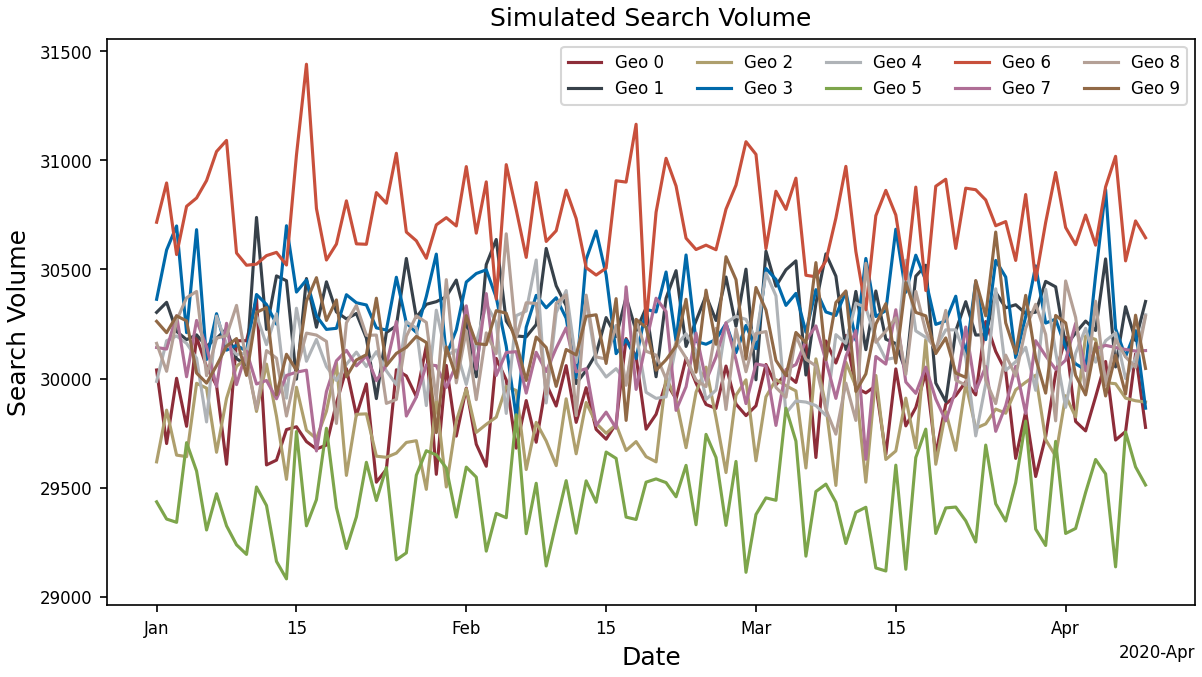

In [ ]:
#| label: fig-model-simulated-search-volume
#| echo: false
#| fig-cap: Simulated search volume from the model.

fig, ax = plt.subplots()
ax = draws.sel(draw=10).plot.line(x="date", hue="geo", ax=ax);
plt.legend(handles=ax, labels=[f"Geo {i}" for i in range(len(ax))], ncols=5);
plt.title("Simulated Search Volume");
plt.ylabel("Search Volume");
plt.xlabel("Date");

## Average Simulated Search Volume and Prediction Interval

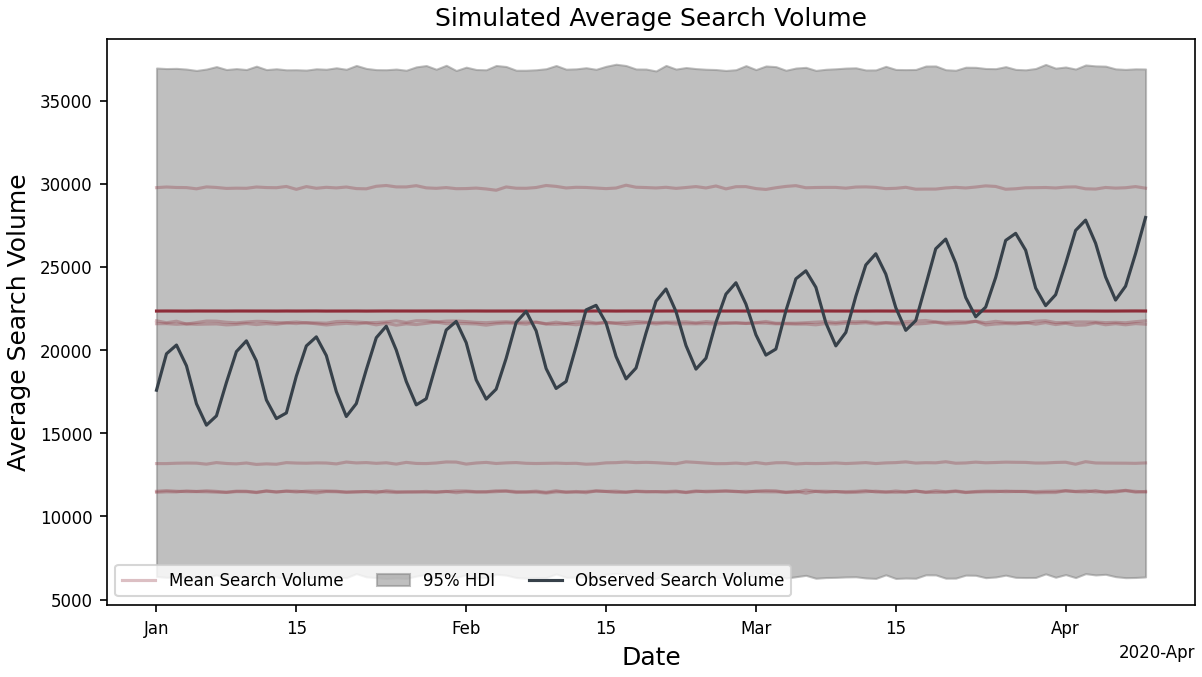

In [ ]:
#| label: fig-model-average-search-volume
#| echo: false
#| fig-cap: Simulated search volume from the model.
mean_geo_draws = draws.mean("geo")

hdi = pm.hdi(mean_geo_draws, hdi_prob=0.95, input_core_dims=[['draw']]).x
fig, ax = plt.subplots()
handles = mean_geo_draws.sel(draw=slice(0, 5)).plot.line(x="date", color='C0', alpha=0.3, ax=ax);
mean_geo_draws.mean("draw").plot.line(x="date", color='C0', ax=ax, label="Mean Search Volume");
fill = plt.fill_between(
    mean_geo_draws.date.values,
    hdi.sel(hdi='lower').values,
    hdi.sel(hdi='higher').values,
    alpha=0.5,
    color="gray",
)
observed_data = data.search_volume.mean("geo").isel(date=slice(0, 100)).plot.line(x='date', color='C1', ax=ax, label="Observed Search Volume");
plt.legend(handles=[handles[0], fill, observed_data[0]], labels=["Mean Search Volume", "95% HDI", "Observed Search Volume"], ncols=3);
plt.title("Simulated Average Search Volume");
plt.ylabel("Average Search Volume");
plt.xlabel("Date");

:::

### 3. Impression Generation Model

This component converts search volume to impressions based on your budget:

- **Budget Effect**: Uses a weighted hill function (shown in the code as `budget_transform(multiplier, competitor_pressure, budget)` [Code -@lst-nonlinear-transform])
- **Competitor Pressure**: A Half-Cauchy distribution parameter that models how difficult it is to win impressions [Code -@lst-budget-model-priors]
- **Impression Rate**: The probability that a search will result in your ad being shown [Code -@lst-impression-rate-model]
- **Final Impressions**: Modeled as a Binomial distribution (either shown or not shown) [Code -@lst-obs-impression-model]

This structure captures the diminishing returns seen in [@fig-imp-response; @fig-click-response], where doubling your budget doesn't double your results.

In [ ]:
#| lst-label: lst-budget-model-priors
#| lst-cap: Define the priors for the budget model. 

# The max precentage of search volume that can be converted to impressions
# Must be between 0 and 1
multiplier = Prior(
    "search_volume_multiplier", 
    prior_name="Beta", 
    alpha=0.5, 
    beta=0.5, 
    dims=tuple()
    )

# The average competitive pressure for bidded keywords
# This can be modeled by keword category, by geo and time
# It is assumed constant for simplicity
# Must be positive but can be large
competitor_pressure = Prior(
    "competitor_pressure", 
    prior_name="HalfCauchy", 
    beta=1, 
    dims=tuple()
    )

In [ ]:
#| lst-label: lst-nonlinear-transform
#| lst-cap: Define a nonlinear hill transformation for the budget model.
def budget_transform(multiplier, competitor_pressure, budget):
    numerator = multiplier * budget
    denominator = budget + competitor_pressure
    return numerator / denominator

In [ ]:
#| lst-label: lst-impression-rate-model
#| lst-cap: Define the model for the impression rate. This is a nonlinear transformation of the budget data.
impression_rate = budget_transform(
    multiplier=multiplier,
    competitor_pressure=competitor_pressure,
    budget=budget_data
)

In [ ]:
#| hide
obs_budget_data = data.budget.isel(date=slice(None, 100)).values

In [ ]:
#| lst-label: lst-obs-impression-model
#| lst-cap: Define the model for the observed impressions.
with search_model:
    imp_rate = handle_dims(
        impression_rate.apply(obs_budget_data), 
        impression_rate._dims, 
        ("date", "geo"))
    impressions_obs = pm.Binomial(
        "impressions_obs",
        n=search_volume_obs,
        p=imp_rate,
        dims=("date", "geo"),
    )

In [ ]:
#| echo: false
draws = pm.draw(impressions_obs, 1000, random_seed=42)
draws = xr.DataArray(
    draws,
    dims=("draw", "date", "geo"),
    coords={
        "draw": np.arange(1000),
        "date": data.date.values[:100],
        "geo": data.geo.values
    },
)

::: {.callout-note}
## Key assumptions and justifications:

- **Hill function** for budget effects: Creates an S-shaped curve that realistically models marketplace dynamics
- **Competitor pressure parameter**: Captures how difficult it is to win impression share in competitive markets
- **Binomial distribution** for impressions: Models the binary outcome (shown/not shown) for each potential search
- **Upper bound** constrained by search volume: You can't get more impressions than there are searches

:::

::: {.panel-tabset}

## Prior Simulated Impressions

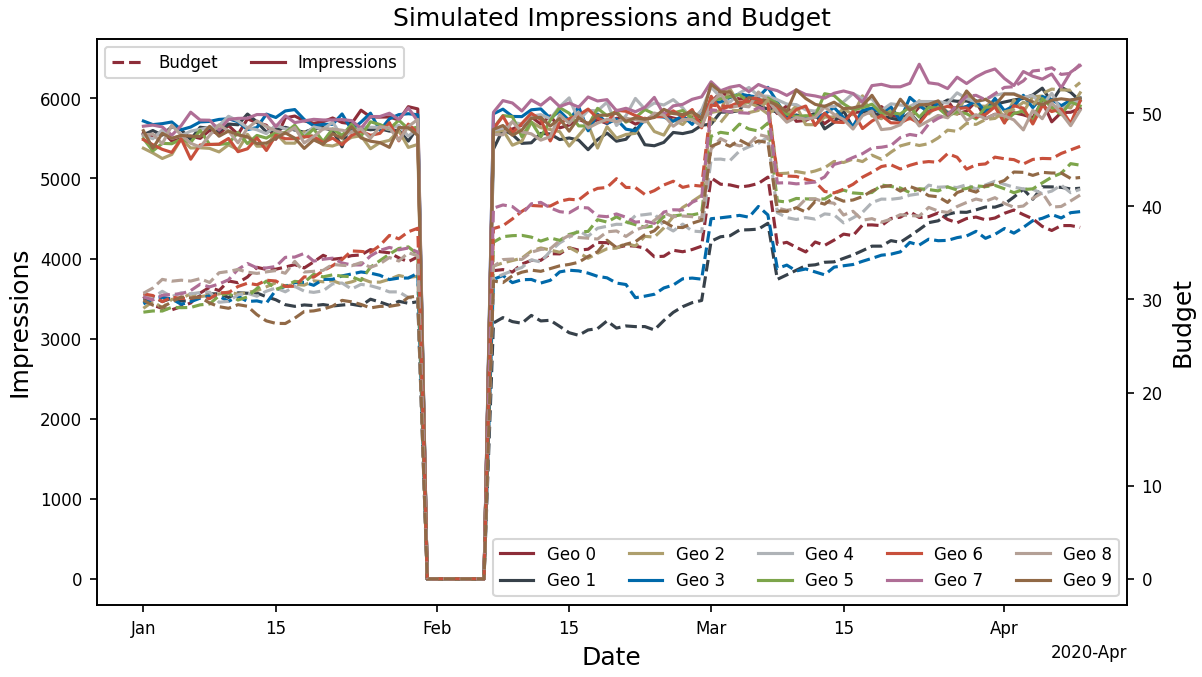

In [ ]:
#| label: fig-model-simulated-search-impressions
#| echo: false
#| fig-cap: Simulated search volume from the model. Note that when budget is 0, impressions are also 0.

fig, ax = plt.subplots()
handles = draws.sel(draw=10).plot.line(x="date", hue="geo", ax=ax);

axs = ax.twinx()
handles_b = data.budget.isel(date=slice(None, 100)).plot.line(x="date", hue="geo", ax=axs, ls='--');
ax.legend(handles=handles, labels=[f"Geo {i}" for i in range(len(handles))], ncols=5);
axs.legend(handles=[handles_b[0], handles[0]], labels=["Budget", "Impressions"], ncols=2);
ax.set_title("Simulated Impressions and Budget");
ax.set_ylabel("Impressions");
ax.set_xlabel("Date");
axs.set_ylabel("Budget");
axs.set_title("");

## Average Impressions

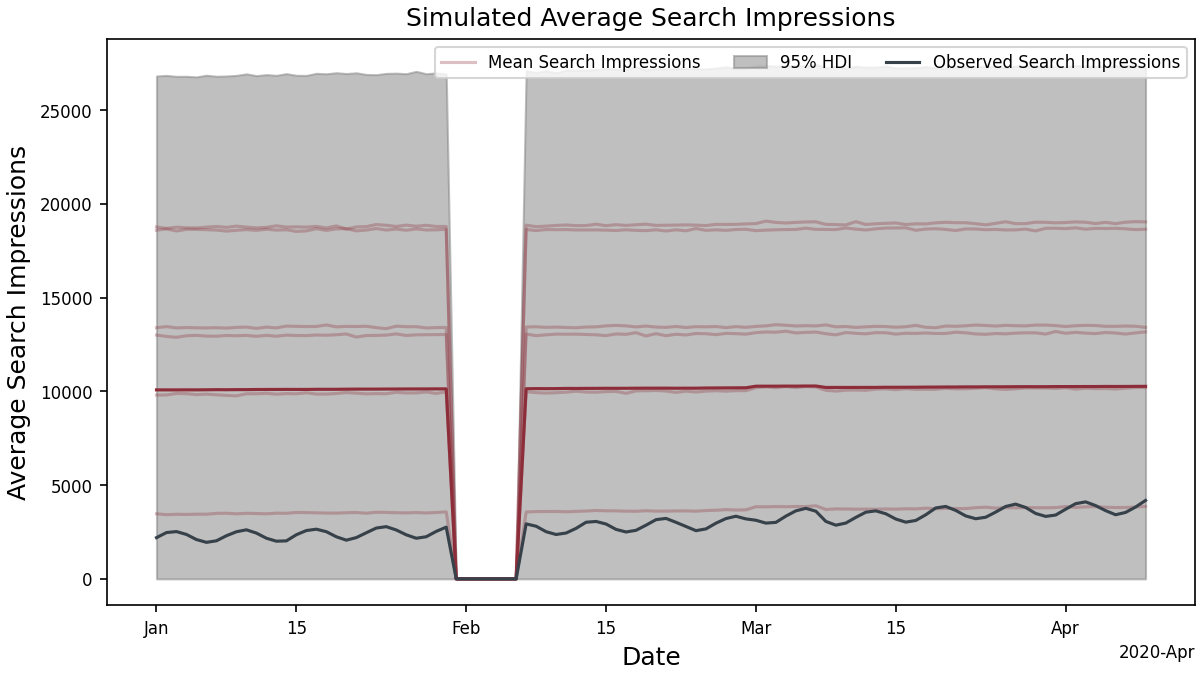

In [ ]:
#| label: fig-model-average-impressions
#| echo: false
#| fig-cap: Simulated impressions from the model.
mean_geo_draws = draws.mean("geo")

hdi = pm.hdi(mean_geo_draws, hdi_prob=0.95, input_core_dims=[['draw']]).x
fig, ax = plt.subplots()
handles = mean_geo_draws.sel(draw=slice(0, 5)).plot.line(x="date", color='C0', alpha=0.3, ax=ax);
mean_geo_draws.mean("draw").plot.line(x="date", color='C0', ax=ax, label="Mean Search Volume");
fill = plt.fill_between(
    mean_geo_draws.date.values,
    hdi.sel(hdi='lower').values,
    hdi.sel(hdi='higher').values,
    alpha=0.5,
    color="gray",
)
observed_data = data.impressions.mean("geo").isel(date=slice(0, 100)).plot.line(x='date', color='C1', ax=ax, label="Observed Search Impressions")
plt.legend(handles=[handles[0], fill, observed_data[0]], labels=["Mean Search Impressions", "95% HDI", "Observed Search Impressions"], ncols=3);
plt.title("Simulated Average Search Impressions");
plt.ylabel("Average Search Impressions");
plt.xlabel("Date");

:::

### 4. Click-Through Rate Model

This predicts how impressions convert to clicks:

- **Base CTR**: The fundamental click probability [Code -@lst-ctr-model]
- **Temporal CTR Patterns**:
  - Short-term periodic effects (customer behavior trends) [Code -@lst-ctr-model]
  - Long-term periodic effects (seasonal buying patterns) [Code -@lst-ctr-model]
- **Final Clicks**: Modeled as a Binomial distribution based on these probabilities [Code -@lst-obs-click-model]

In [ ]:
#| lst-label: lst-ctr-model
#| lst-cap: Define the CTR model. 
base_ctr = Prior(
    "base_ctr", 
    prior_name="Normal", 
    mu=0, 
    sigma=1
)

ctr = ((
    short_periodic_ctr 
    + long_periodic_ctr 
    + base_ctr
)(time_data)
).transform(pt.sigmoid)


In [ ]:
#| lst-label: lst-obs-click-model
#| lst-cap: Define the model for the observed clicks.
with search_model:
    ctr = handle_dims(
        ctr.apply(obs_budget_data), 
        ctr._dims, 
        ("date", "geo"))
    clicks_obs = pm.Binomial(
        "clicks_obs",
        n=impressions_obs,
        p=ctr,
        dims=("date", "geo"),
    )

In [ ]:
#| echo: false
draws = pm.draw(clicks_obs, 1000, random_seed=42)
draws = xr.DataArray(
    draws,
    dims=("draw", "date", "geo"),
    coords={
        "draw": np.arange(1000),
        "date": data.date.values[:100],
        "geo": data.geo.values
    },
)

::: {.callout-note}
## Key assumptions and justifications:
- **Sigmoid transformation**: Ensures click probabilities stay between 0 and 1
- **Binomial distribution** for clicks: Models the binary outcome (clicked/not clicked) for each impression
- **Temporal components**: Captures how user behavior varies by day of week and season
- **Hierarchical structure**: Allows for geographic differences in click behavior
:::

::: {.panel-tabset}

## Prior Simulated Clicks

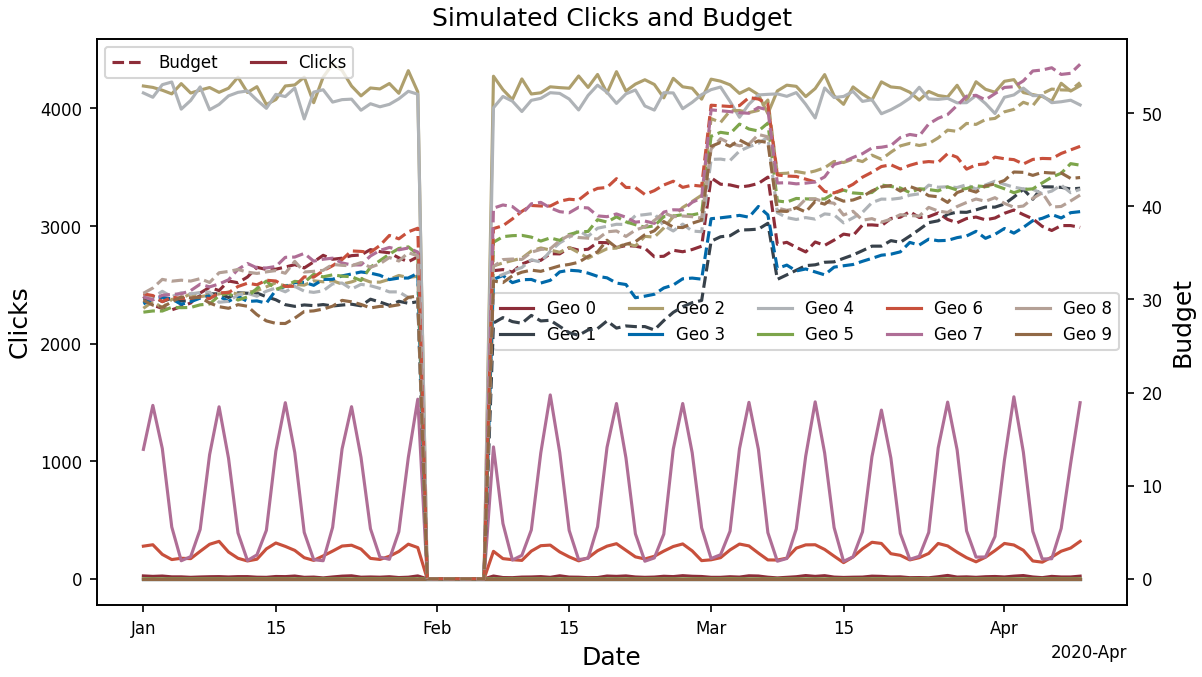

In [ ]:
#| label: fig-model-simulated-clicks
#| echo: false
#| fig-cap: Simulated search clicks from the model. Note that when budget is 0, clicks are also 0.

fig, ax = plt.subplots()
handles = draws.sel(draw=0).plot.line(x="date", hue="geo", ax=ax);

axs = ax.twinx()
handles_b = data.budget.isel(date=slice(None, 100)).plot.line(x="date", hue="geo", ax=axs, ls='--');
ax.legend(handles=handles, labels=[f"Geo {i}" for i in range(len(handles))], ncols=5);
axs.legend(handles=[handles_b[0], handles[0]], labels=["Budget", "Clicks"], ncols=2);
ax.set_title("Simulated Clicks and Budget");
ax.set_ylabel("Clicks");
ax.set_xlabel("Date");
axs.set_ylabel("Budget");
axs.set_title("");

## Average Clicks

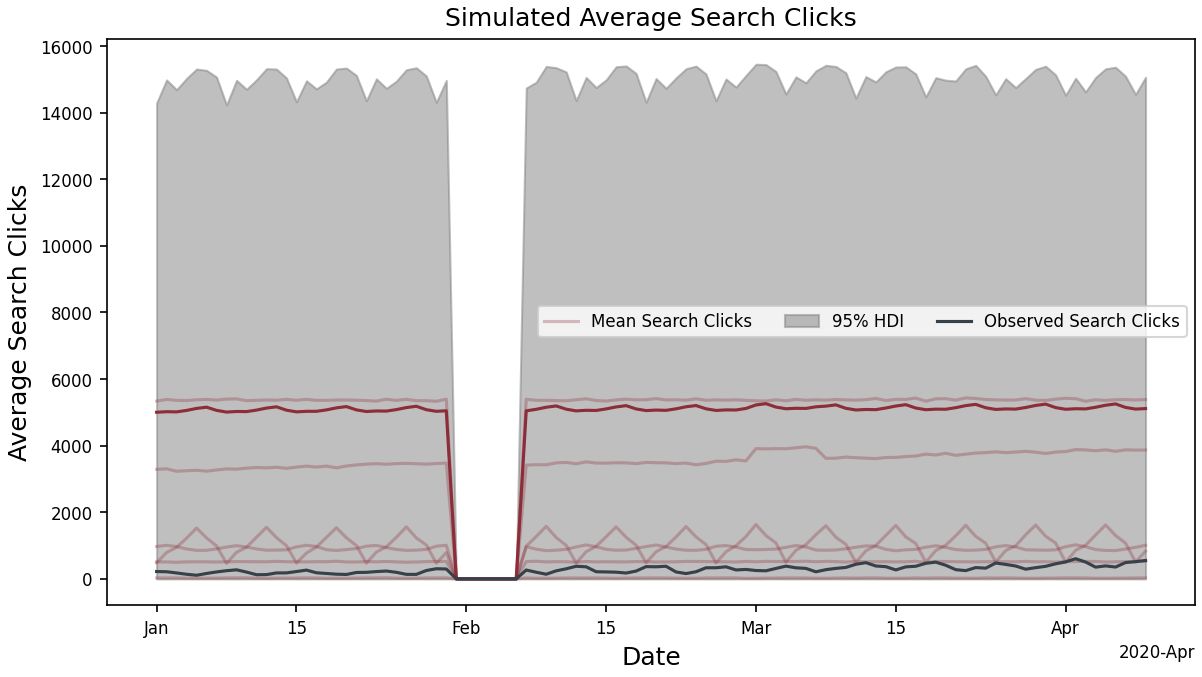

In [ ]:
#| label: fig-model-average-clicks
#| echo: false
#| fig-cap: Simulated clicks from the model.
mean_geo_draws = draws.mean("geo")

hdi = pm.hdi(mean_geo_draws, hdi_prob=0.95, input_core_dims=[['draw']]).x
fig, ax = plt.subplots()
handles = mean_geo_draws.sel(draw=slice(0, 5)).plot.line(x="date", color='C0', alpha=0.3, ax=ax);
mean_geo_draws.mean("draw").plot.line(x="date", color='C0', ax=ax, label="Mean Clicks");
fill = plt.fill_between(
    mean_geo_draws.date.values,
    hdi.sel(hdi='lower').values,
    hdi.sel(hdi='higher').values,
    alpha=0.5,
    color="gray",
)
observed_data = data.observed_clicks.mean("geo").isel(date=slice(0, 100)).plot.line(x='date', color='C1', ax=ax, label="Observed Clicks")
plt.legend(handles=[handles[0], fill, observed_data[0]], labels=["Mean Search Clicks", "95% HDI", "Observed Search Clicks"], ncols=3);
plt.title("Simulated Average Search Clicks");
plt.ylabel("Average Search Clicks");
plt.xlabel("Date");

:::

## The Complete Probabilistic Model

The full model integrates all these components in a Bayesian framework:

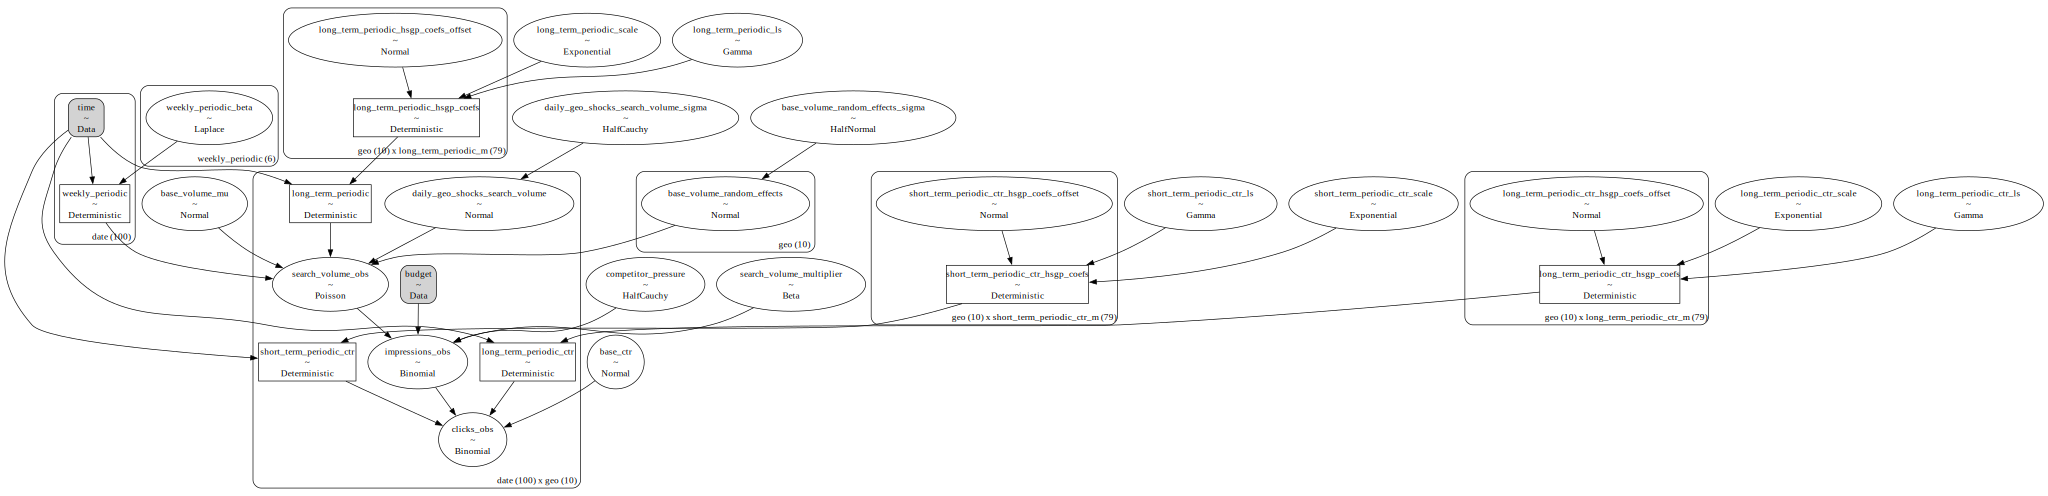

In [ ]:
#| echo: false
#| label: fig-full-pymc-model
#| fig-cap: Full PyMC model for the search volume and impressions data.

pm.model_to_graphviz(search_model)

This probabilistic approach offers several advantages:

1. **Uncertainty quantification**: Provides confidence intervals around predictions
2. **Parameter learning**: Infers key parameters like competitor pressure from your historical data
3. **Future forecasting**: Projects expected performance under different budget scenarios
4. **Anomaly detection**: Identifies when performance diverges from expectations

## Fitting the Model

In [ ]:
#| echo: false
train_data = data.isel(date=slice(None, 100))

In [ ]:
#| eval: false
def partial_observe(model, obs_data, input_data, coords, target_accept=.70):
    with pm.observe(model, obs_data):
        pm.set_data(input_data, coords=coords)
        trace = pm.sample(1000, tune=1000, target_accept=target_accept, nuts_sampler='nutpie')
    return trace

search_volume_trace = partial_observe(
    search_model, 
    {'search_volume_obs': train_data.search_volume.values,
    'impressions_obs': train_data.impressions.values,
    'clicks_obs': train_data.observed_clicks.values}, 
    {'time': train_data['time'].values,
    'budget': train_data.budget.values}, 
    coords)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.06,1023
,2000,2,0.07,63
,2000,0,0.06,63
,2000,0,0.07,255


## Practical Applications: Optimizing Your Strategy

This model supports several critical business decisions:

### Budget Optimization

- **Finding the inflection point**: Identify where additional spending faces significantly diminishing returns
- **Scenario testing**: Predict outcomes from different budget levels before committing resources

### Geographic Allocation

- **Market efficiency comparison**: Identify which regions provide better returns on ad spend
- **Reallocation strategies**: Shift budget from saturated to more responsive markets

### Seasonal Planning

- **Preemptive adjustments**: Increase budget before seasonal demand spikes
- **Efficiency preservation**: Reduce spending during predictable low-volume periods

### Anomaly Detection

- **Performance monitoring**: Identify when actual results deviate from expectations
- **Competitive intelligence**: Detect when marketplace dynamics change significantly

## Limitations and Considerations

While powerful, the model comes with important caveats:

1. **Competitor behavior assumptions**: The model assumes competitor pressure changes slowly; rapid competitive shifts may reduce forecast accuracy

2. **Market disruptions**: Major external events (like a pandemic) may invalidate historical patterns

3. **New market limitations**: Limited historical data for new geographic regions may reduce forecast accuracy initially

4. **Attribution windows**: The model assumes clicks are attributed to impressions within the same time window

## Next Steps: Implementing the Model

To implement this model for your business:

1. **Data integration**: Connect your search advertising platform data
2. **Historical fitting**: Train the model on your past performance
3. **Scenario planning**: Test different budget allocation strategies
4. **Continuous refinement**: Update the model as new data becomes available

Our team can help you with each of these steps, from data preparation to strategic interpretation of the results.

## Conclusion: The Value of Sophisticated Modeling

Traditional approaches to search advertising often rely on simplistic assumptions that don't capture real-world complexity. Our probabilistic model overcomes these limitations by:

- **Respecting causal structure**: Distinguishing what you control from what you don't
- **Capturing non-linearity**: Modeling diminishing returns and saturation effects
- **Accounting for uncertainty**: Providing confidence intervals around predictions
- **Integrating multiple factors**: Combining seasonality, geography, and marketplace dynamics

This sophisticated approach provides more accurate forecasts and enables smarter budget allocation decisions across time periods and geographic markets.